In [1]:
#This cell is setting up the necessary libraries for the notebook.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib ipympl
import time


# specific modules for ode solving and fast numerical computation
from scipy.integrate import solve_ivp
from numba import njit


## Solving non-steady heat equation using EDO solver from scipy

### Theoretical background

For this example let’s consider the 1D heat equation in its non-steady form:


$$
\rho  c_p \frac{\partial T}{\partial t} = k  \frac{\partial^2 T}{\partial x^2} + s(x,t) - hb  T
$$

Where $\rho$ is the density, $c_p$ is the specific heat, $k$ is the thermal conductivity, $s(x,t)$ is the source term, and $hb$ is a coefficient that allows to take into account the heat transfer coefficient by convection along the x-axis (it models the heat loss along by the side all along the sample).

Zero flux boundary conditions are considered at extremities ($x=0$ and $x=x_{max}$):
$$
\left(\frac{\partial T}{\partial x}\right)_{x=0} = 0
$$
$$
\left(\frac{\partial T}{\partial x}\right)_{x=x_{max}} = 0
$$

### Resolution of the heat equation
To solve numerically this kind of problem, an explicit integration scheme is often used (Euler, RK4, ...).
But this may lead to numerical instabilities (the solution may diverge) if the time step is not small enough.
The stability condition is given by the following equation:
$$
\Delta t < \frac{\Delta x^2}{2 \alpha}
$$
Where $\Delta t$ is the time step, $\Delta x$ is the spatial discretization step, and $\alpha$ is the thermal diffusivity ($\alpha = \frac{k}{\rho c_p}$).

One of the solutions to overcome this stability issues is to use an implicit integration scheme.
To do so, in this example we used the EDO solver from scipy to solve the heat equation. 
It provides a large choice of integration scheme (explicite and implicite), here we used the BDF (Backward Differentiation Formula) scheme.

### Formulation of the heat equation as an EDO system
The heat equation is formulated as a system of first order differential equations:

$$
\frac{\partial T}{\partial t} = \frac{k}{\rho c_p}  \frac{\partial^2 T}{\partial x^2} + \frac{s(x,t)}{\rho c_p} - \frac{hb}{\rho c_p} T
$$

The system of equations can be solved using the EDO solver from scipy, we need to compute the Laplacian of the temperature field $\frac{\partial^2 T}{\partial x^2}$:

$$
\frac{\partial^2 T}{\partial x^2} = \frac{T_{i+1} - 2 T_i + T_{i-1}}{\Delta x^2}
$$

Where $\Delta x$ is the spatial discretization step.

## Implementation
### Laplacian estimation function
for this function we used the @njit decorator from numba to speed up the computation.

In [2]:
@njit
def lap_loop(T):
    NX = len(T)
    Tp = np.zeros((NX))
    for i in range(1, NX-1):
            Tp[i]=((T[i-1] - 2. * T[i] + T[i+1]))
    return Tp


### Source function
The source function apply a volumes heat source in the middle of the sample ($45 mm<x<75 mm$) during 3s ($2s<t<5s$).
The magnitude of the source is denoted by the $q$ parameter ($(W/m^3)*m$).

In [3]:
@njit
def source(x,t,q):
    """
    source terms of the heat equation
    """
    s = np.where((x>45e-3) & (x<75e-3) & (t>2.) & (t<5.), q, 0.)
    return s

### ODE diff function
The ODE diff function is the function that will be passed to the EDO solver, it takes as input the current temperature field, the current time and extra parameters.
It returns derivative of $T$ respect to time $\frac{\partial T}{\partial t}$.

The zero flux boundary conditions are implemented into this function.

In [4]:
def Tp_1D(t, T, NX, x, dx, rhoCp, k, q, hb):
    """
    compute DT/dt for the 1D heat eq
    """
    Tp = np.zeros((NX))
    # Laplacian estimation using finite difference method
    coef = k / (dx**2)    
    Tp = coef * lap_loop(T)
    # Heat loss by convective changes by the side of the sample hb = 2*hl / e    
    Tp -= hb * T # heat loss by convection on the side of the sample
    # source term
    Tp += source(x, t,q)

    # BC 
    # zeor flux at the extremities
    Tp[0] = Tp[1]
    Tp[NX-1] = Tp[NX-2]

    # divide by rho*Cp
    Tp /=  rhoCp
    return Tp

## Physical parameters and simulation setup

Here we model the conduction in a sample made of steel. 
The dimensions of the sample are given in the data dictionary.
In this dictionary we also define the physical parameters of the material and the simulation setup.

Some extra computations are made before solving the ODE system:
- the spatial discretization step $\Delta x$ is computed from the number of points in the spatial domain and the length of the sample
- the initial temperature field is set to zero
- the time vector is computed from the simulation time and the time step

Finally, the ODE system is solved using the scipy EDO solver.


In [5]:
# data of the problem
data ={
    "k": 50., # thermal conductivity [W/m/K]
    "rho": 7850., # density [kg/m3]
    "Cp": 465., # specific heat [J/kg/K]
    "e": 1.55e-3, # thickness of the sample [m]
    "l": 15e-3, # width of the sample [m]
    "hl": 10., # heat transfer coefficient by convection [W/m2/K]
    "t_max": 10., # duration of the simulation [s]
    "x_max": 120e-3, # length of the sample [m]
    "nt": 80, # number of time steps
    "nx": 100,# number of space steps
    "q" : 18/30e-3/1.55e-3, # source term [W/m3*m] (18 W applied on 30 mm length)
    } 


# exenage by convection on the side of the sample : hb = hl*P/A
P = 2*(data["e"]+data["l"])
A = data["e"]*data["l"]
hb = (data["hl"] * P/A)

# space and time discretization
x = np.linspace(0., data["x_max"], data["nx"])
dx= x[1]-x[0]
t_eval = np.linspace(0., data["t_max"], data["nt"])

# initial temperature
T0 = np.zeros_like(x)

# args to pass to the solver
rhoCp= data["rho"] * data["Cp"]
args = (data["nx"], x, dx, rhoCp, data["k"], data["q"], hb)


# time integration
print("Solve 1D heat equation")
t0 = time.time()
Duration = data["t_max"]
sol = solve_ivp(Tp_1D, [0, Duration],
                T0,
                t_eval=t_eval,
                method='BDF',
                vectorized=False,
                args=args)
print("Done in {:.2f} s".format(time.time()-t0))


Solve 1D heat equation
Done in 2.10 s


## Ploting the results
The first plot shows the temperature field repect to time and space.
The second plot the source term repect.

The heat splot can be seen in the middle of the sample. 
It relsuts in a temperature increase of about $0.3°$.

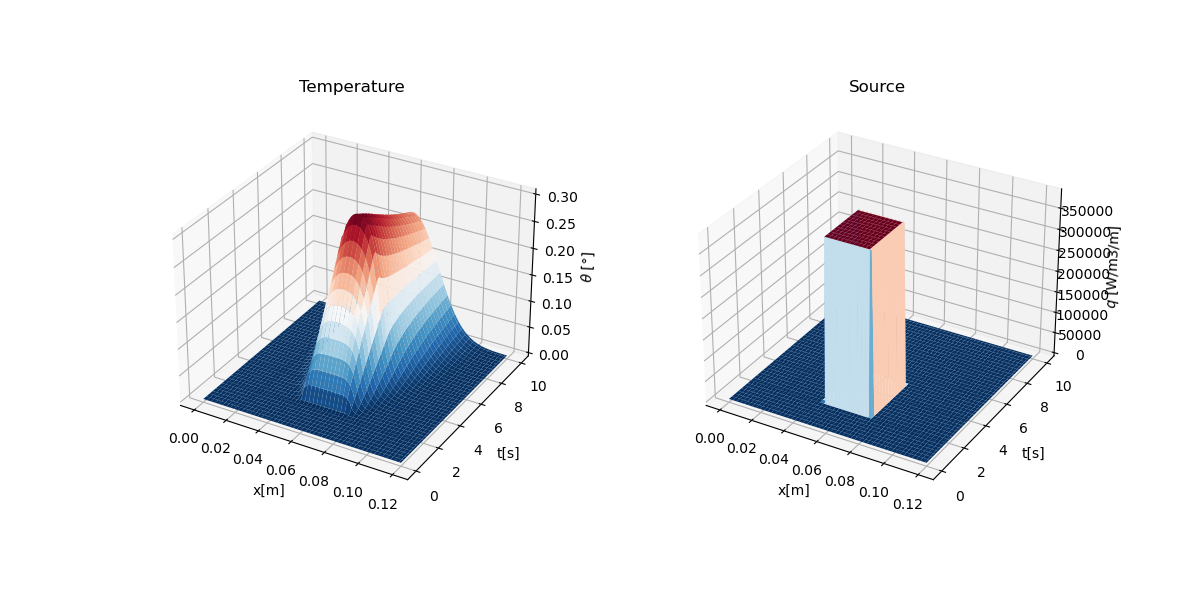

In [6]:
# create a figure with two subplots
cmap = "RdBu_r"
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# create meshgrid for x and t
xg, tg = np.meshgrid(x, t_eval)

# plot the temperature on the first subplot
ax1.plot_surface(xg, tg, sol.y.T, cmap=cmap, edgecolor='none')
ax1.set_xlabel("x[m]")
ax1.set_zlabel(r"$\theta$ [°]")
ax1.set_ylabel("t[s]")
ax1.set_title("Temperature")

# plot the source on the second subplot
ax2.plot_surface(xg, tg, source(xg, tg, data["q"]), cmap=cmap, edgecolor='none')
ax2.set_xlabel("x[m]")
ax2.set_zlabel(r"$q$ [W/m3/m]")
ax2.set_ylabel("t[s]")
ax2.set_title("Source")

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# display the figure
plt.show()


## Conclusion
This example shows how to solve the heat equation using the EDO solver from scipy.
Some numerical difficulties are managed by the ODE solver which make the implementation easier.
This exemple deals with 1D heat conduction, but the same approach can be used for 2D and 3D heat conduction.